<a href="https://colab.research.google.com/github/sarloet/Foundations-of-Data-Science/blob/main/SkeletonCIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical 3: CIFAR-10

This is the second task of Practical 3. Your task is to use **transfer learning** to build a convolutional neural network to tackle the CIFAR-10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html). 
You could select an existing trained model (VGG16 excluded) from Keras (https://keras.io/api/applications/) and fine-tune it to build a classifier for CIFAR-10.

We will grade your code based on the accuracy of your model. 
Your CNN should achieve at least an accuracy of 75% to pass the practical.
You can get 5 bonus points by achieving an accuracy of 85%+.


The model files might be too large to be uploaded to GitHub. 
Please use the following link to upload your models: https://seafile.ifi.uzh.ch/u/d/695f63e725b641ed8633/

Name the model file `{repository_name}-CIFAR10.h5`. For example, if your repository is FDS22-M0, you should name the model file `FDS22-M0-CIFAR10.h5`. If you are not satisfied with the model you have uploaded, you can upload a new one with the same name. We will only look at the newest model. Nevertheless, try to upload as few times as possible, since the online drive has a limited amount of space. 

## Import the libraries

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

In [11]:
tf.__version__

'2.9.2'

In [12]:
tf.keras.__version__

'2.9.0'

## Prepare the dataset

In this block, you will prepare the data for the training, such as apply the preprocess function of your selected model and perform data augmentation. 

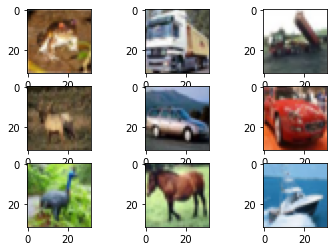

In [13]:
from keras.datasets import cifar10
from keras.applications.vgg19 import preprocess_input

(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()

for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train_full[i])
plt.show()

X_train_full.shape


X_train_full = X_train_full.astype('float32')

# normalisation
# X_train_full = X_train_full/255.0
# X_test = X_test/255.0

# vgg19 preprocess
X_train_full = preprocess_input(X_train_full)
X_test = preprocess_input(X_test)

# one-hot encoding
y_train_full = keras.utils.to_categorical(y_train_full, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

# get validation dataset
np.random.seed(42) # we set the random seed to make sure everytime the data is shuffled in the same way 
shuffled_indices = np.random.permutation(X_train_full.shape[0])
X_valid, X_train = X_train_full[shuffled_indices[:5000]], X_train_full[shuffled_indices[5000:]]
y_valid, y_train = y_train_full[shuffled_indices[:5000]], y_train_full[shuffled_indices[5000:]]


## Build and train the model

Build and train your model. 

In [20]:
# TODO: load the model you selected


# Scaling the original image to 160 px x 160 px
input_shape = X_train_full.shape[1:]
inputs = keras.Input(shape=input_shape)
upscale = (keras.layers.Lambda(lambda x: tf.image.resize(x, [160, 160])))(inputs)




vgg19_model = tf.keras.applications.vgg19.VGG19(include_top=False, input_shape=(160,160,3), weights='imagenet',input_tensor=upscale)
# when you change the input shape, keras will automatically change the shapes of the other layers accordingly . to meet the new input shape
vgg19_model.summary()



# TODO: Transfer learning - build your own model based on the selected model

x = vgg19_model.output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(512,activation='relu')(x) # dense layer 1
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(512,activation='relu')(x) # dense layer 2
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.4)(x)
output = keras.layers.Dense(units=10, activation='softmax')(x) # output layer with softmax activation
model = keras.Model(inputs=vgg19_model.input, outputs=output)

# freeze the layers from VGG16 
for layer in vgg19_model.layers:
    layer.trainable=False

model.summary()



model.compile(optimizer=keras.optimizers.Adam(lr=1e-5),            #Adam(lr=1e-5)
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


callback= tf.keras.callbacks.EarlyStopping(monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="min")


model.fit(X_train, y_train, batch_size=32, epochs=3, validation_data=(X_valid, y_valid))


history = model.fit(X_train, y_train, batch_size=32, epochs=30, 
                    validation_data=(X_valid, y_valid),callbacks=callback)


Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda_4 (Lambda)           (None, 160, 160, 3)       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/3
1407/1407 [==============================] - 152s 107ms/step - loss: 1.5088 - accuracy: 0.5272 - val_loss: 0.5960 - val_accuracy: 0.8084
Epoch 2/3
1407/1407 [==============================] - 150s 107ms/step - loss: 0.7737 - accuracy: 0.7476 - val_loss: 0.4573 - val_accuracy: 0.8518
Epoch 3/3
1407/1407 [==============================] - 150s 107ms/step - loss: 0.6025 - accuracy: 0.8014 - val_loss: 0.4001 - val_accuracy: 0.8680
Epoch 1/30
1407/1407 [==============================] - 150s 107ms/step - loss: 0.5063 - accuracy: 0.8313 - val_loss: 0.3721 - val_accuracy: 0.8782
Epoch 2/30
1407/1407 [==============================] - 150s 106ms/step - loss: 0.4411 - accuracy: 0.8515 - val_loss: 0.3541 - val_accuracy: 0.8828
Epoch 3/30
1407/1407 [==============================] - 150s 106ms/step - loss: 0.3913 - accuracy: 0.8675 - val_loss: 0.3425 - val_accuracy: 0.8850
Epoch 4/30
1407/1407 [==============================] - 150s 107ms/step - loss: 0.3419 - accuracy: 0.8854 - val_los

In [21]:
# show the structure of your model
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda_4 (Lambda)           (None, 160, 160, 3)       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       1475

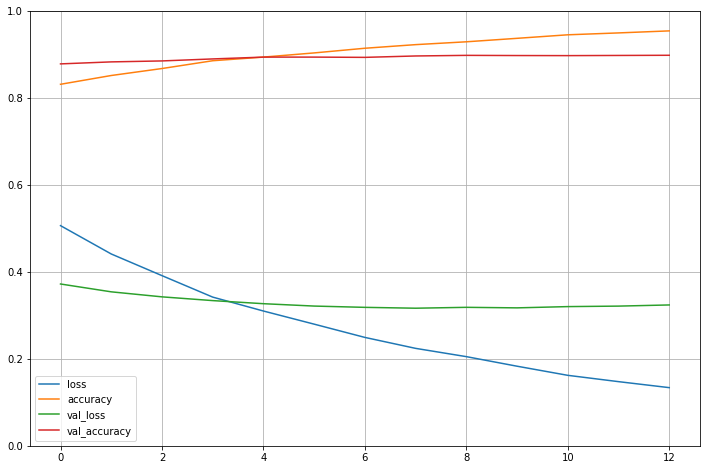

In [22]:
# Assume you have stored the training history in the variable "history"
# Show the learning curves
pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.gca().set_ylim(0, 1)
plt.grid(True)
plt.show()

## Save the model

Save and upload your trained model to the **Seafile link** we provided to you. You can upload it multiple times. We will consider only the newest uploaded model. 

In [23]:
model.save('FDS22-M024-CIFAR10.h5') # change the file name according to your repository name


## Load the model and evaluate it on the test data

In [24]:
model = keras.models.load_model('FDS22-M024-CIFAR10.h5')
model.evaluate(X_test, y_test)

313/313 [==============================] - 30s 96ms/step - loss: 0.3350 - accuracy: 0.8950


[0.33496007323265076, 0.8949999809265137]

## Short report

Please write a few sentences explaining how you build and train the model. Please include the decisions you made, such as how you decide the number of layers reused from the selected model and the difficulties you met.